Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0480
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0106
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0112
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0110
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0101
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0110
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0105
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0108
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0108
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0104
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0107
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0104
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0104
Epoch 14/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0108
Epoch 15/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0106
Epoch 16/20
68/

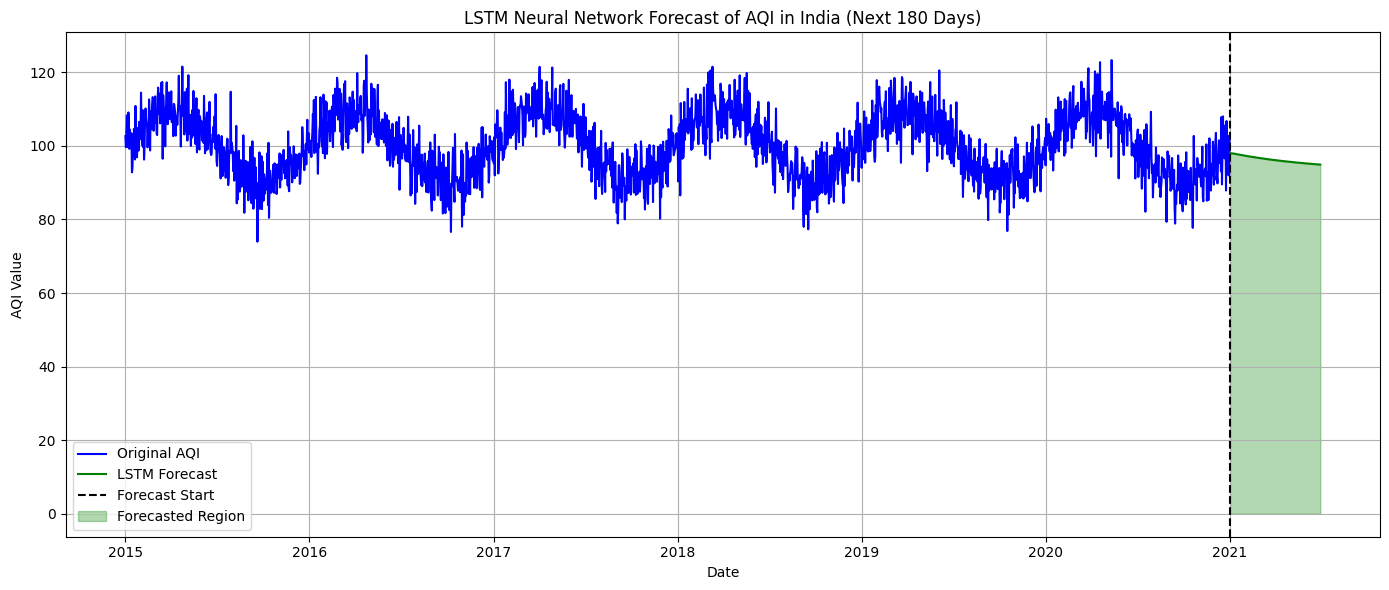

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Step 1: Generate synthetic AQI dataset (from your code)
np.random.seed(42)
date_range = pd.date_range(start='2015-01-01', end='2020-12-31', freq='D')
aqi_values = 100 + 10 * np.sin(2 * np.pi * date_range.dayofyear / 365.25) + np.random.normal(0, 5, len(date_range))

df = pd.DataFrame({
    'Date': date_range,
    'Country': 'India',
    'AQI Value': aqi_values
})

# Step 2: Prepare time series
df_country = df[df['Country'] == 'India'].groupby("Date")['AQI Value'].mean()
df_country = df_country.asfreq('D').interpolate()

# Step 3: Normalize AQI values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_country.values.reshape(-1, 1))

# Step 4: Create sequences for supervised learning
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_sequences(scaled_data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 5: Build and train LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32, verbose=1)

# Step 6: Forecast next 180 days
forecast_days = 180
input_seq = scaled_data[-time_steps:]
forecast = []

for _ in range(forecast_days):
    pred_input = input_seq[-time_steps:].reshape(1, time_steps, 1)
    pred = model.predict(pred_input, verbose=0)
    forecast.append(pred[0, 0])
    input_seq = np.append(input_seq, pred, axis=0)

forecast_scaled = np.array(forecast).reshape(-1, 1)
forecast_actual = scaler.inverse_transform(forecast_scaled)

# Step 7: Prepare forecast series and dates
forecast_dates = pd.date_range(start=df_country.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
forecast_series = pd.Series(forecast_actual.flatten(), index=forecast_dates)

# Step 8: Plot LSTM Forecast
plt.figure(figsize=(14, 6))
plt.plot(df_country, label='Original AQI', color='blue')
plt.plot(forecast_series, label='LSTM Forecast', color='green')
plt.axvline(x=df_country.index[-1], color='black', linestyle='--', label='Forecast Start')
plt.fill_between(forecast_series.index, forecast_series.values,
                 color='green', alpha=0.3, label='Forecasted Region')

plt.title('LSTM Neural Network Forecast of AQI in India (Next 180 Days)')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
